In [5]:
import numpy as np
import numpy.matlib as matlib
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


In [6]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)


Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [7]:
# Replace the ID with ID of file you want to access
# To get this ID, right-click on the name of the appropriate file in your 
# downloaded = drive.CreateFile({'id':'1uhaemiBL_mWEHTilB1tWmE8G9gD5IJgp'}) 
# downloaded.GetContentFile('time_series_covid_19_confirmed.csv') 

Step 2: Read the Data and verify its format!

In [8]:
import pandas as pd
data = pd.read_csv('time_series_covid_19_confirmed.csv') 
print("The shape of data=",data.shape)
data.head()

The shape of data= (266, 225)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551


Step 3: Original data has [266x225] dimensions. Let's use only 50 rows and 100 columns.

In [9]:
rows=50
cols=100
data_new=data.iloc[0:rows,4:cols+4]
print(data_new.shape)

(50, 100)


In [10]:
#view the sub-sectioned data
data_new.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,0,0,0,0,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,0,0,0,0,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
2,0,0,0,0,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,0,0,0,0,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
4,0,0,0,0,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27


Step 4: Convert the Tablular data to format {X,Y}, where X={Longitude, Latitude, Date}, Y={#infected}

In [11]:
# Finding the date indices
import matplotlib.pyplot as plt
data_row=data_new.sum(axis=0)
days=range(0,data_row.shape[0])
days_mat=matlib.repmat(np.array(days),data_new.shape[0],1)
print(days_mat.shape)

(50, 100)


In [12]:
# Let's create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)
for r in range(days_mat.shape[0]): #all locations
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_new[r,:],((days_mat.shape[1],1)))

In [13]:
print(np.shape(X))
#Data Preparation is Done!

(5000, 3)


Step 5: Let's Plot the Data to see the converted Data format!

(5000, 3)


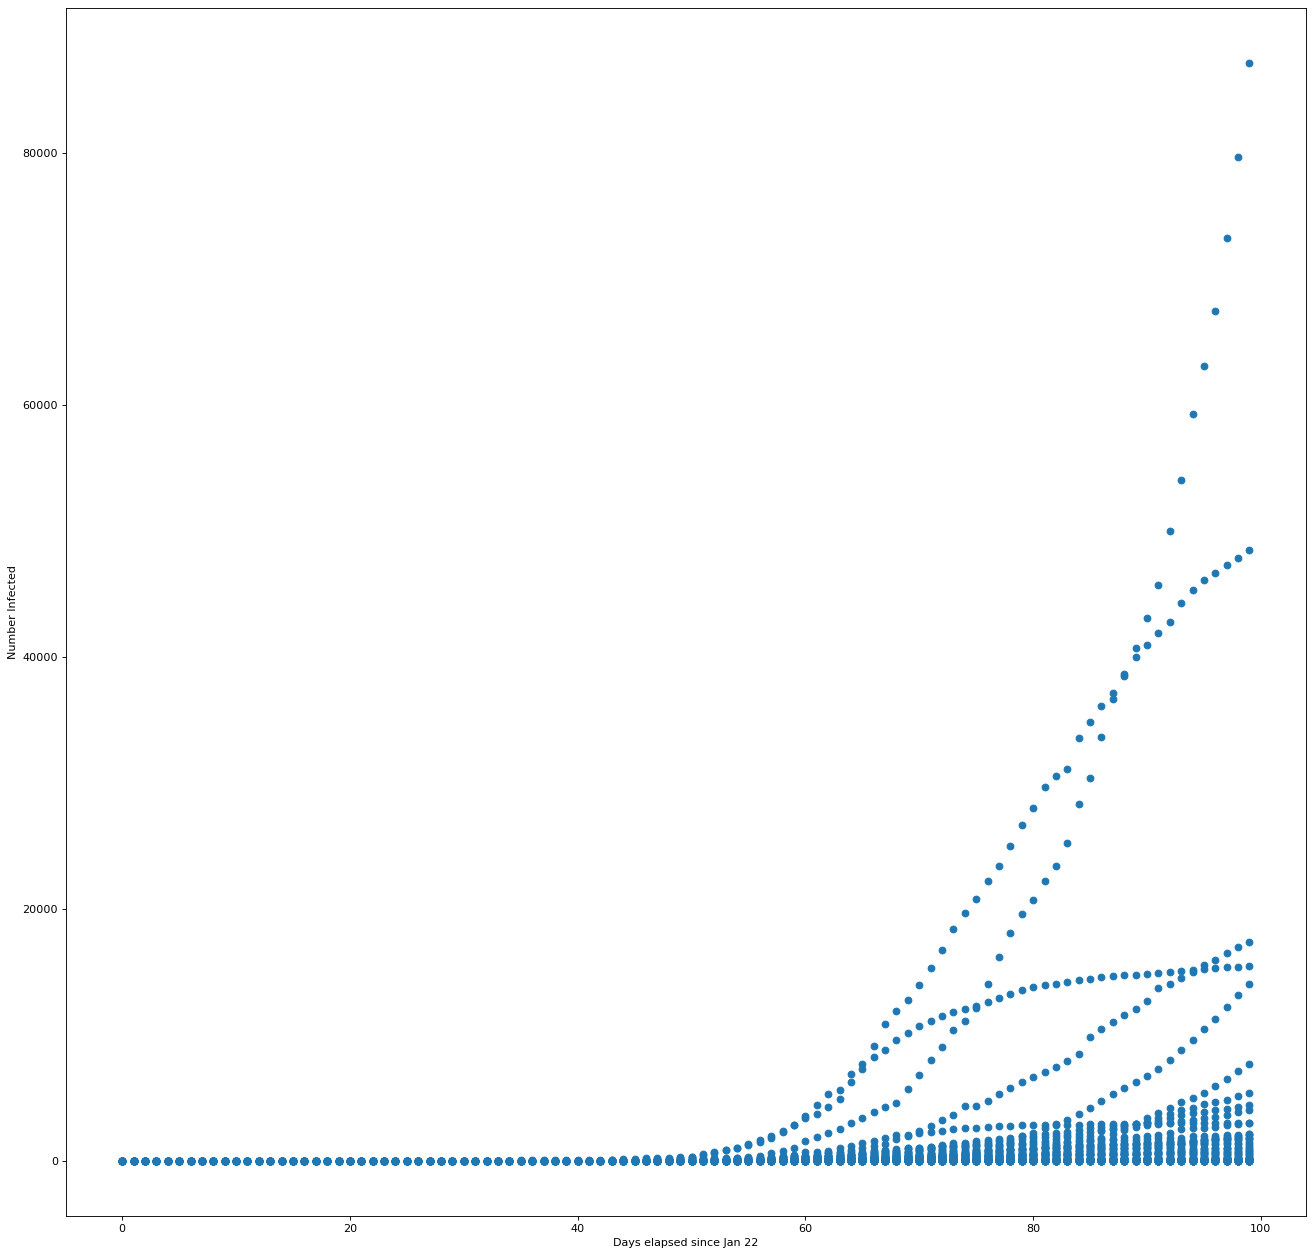

In [14]:
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')
print(np.shape(X))

Step 6: Let's spilt the data to training and test (70% train, 30% test)

In [15]:
# Goal 1: Fit regression model for (days vs infections)
from sklearn.model_selection import train_test_split
# Split data into train and test
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Step 7: Let's fit Polynomial features of degree 3 to the features. This results in dimensions going from 3 to 20!

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3)
# Transform both the train and test data
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
# Fit the model on train data only
clf.fit(X_train, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 20)
Linear Regression Coefficients are= [[ 0.00000000e+00  1.49472285e+00 -1.77011169e+01 -7.44377620e+00
  -2.62371164e+00 -1.66783679e-01 -1.32523607e+00  1.32613637e-01
   1.60019698e-01 -5.80740444e-01  4.74622499e-02  8.72080430e-03
   4.50831003e-02 -2.04127549e-03  1.26028661e-02  2.75122310e-03
   2.97102909e-04 -9.33173379e-04 -3.45730697e-03  9.73845530e-03]]
constant coefficient= [515.00766133]


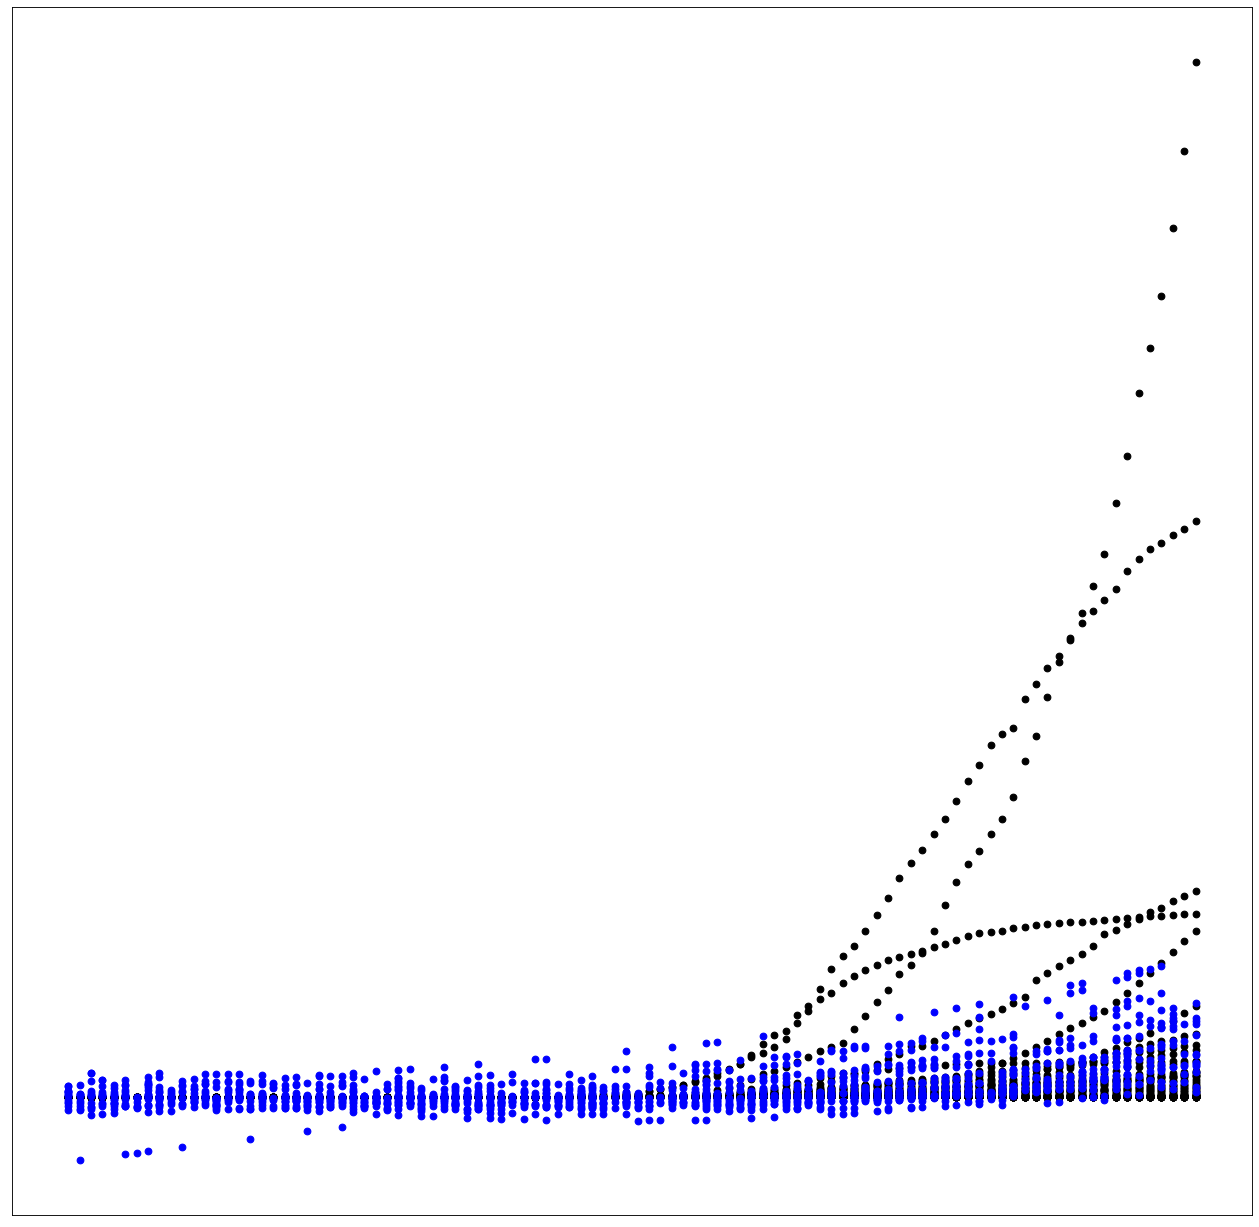

In [17]:
# Predict regression outcome on test data
y_pred = clf.predict(X_test)
# next plot predictions
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In the image above, black points are training and blue ones are test!

In [18]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_test, y_pred))

20560548.002744343


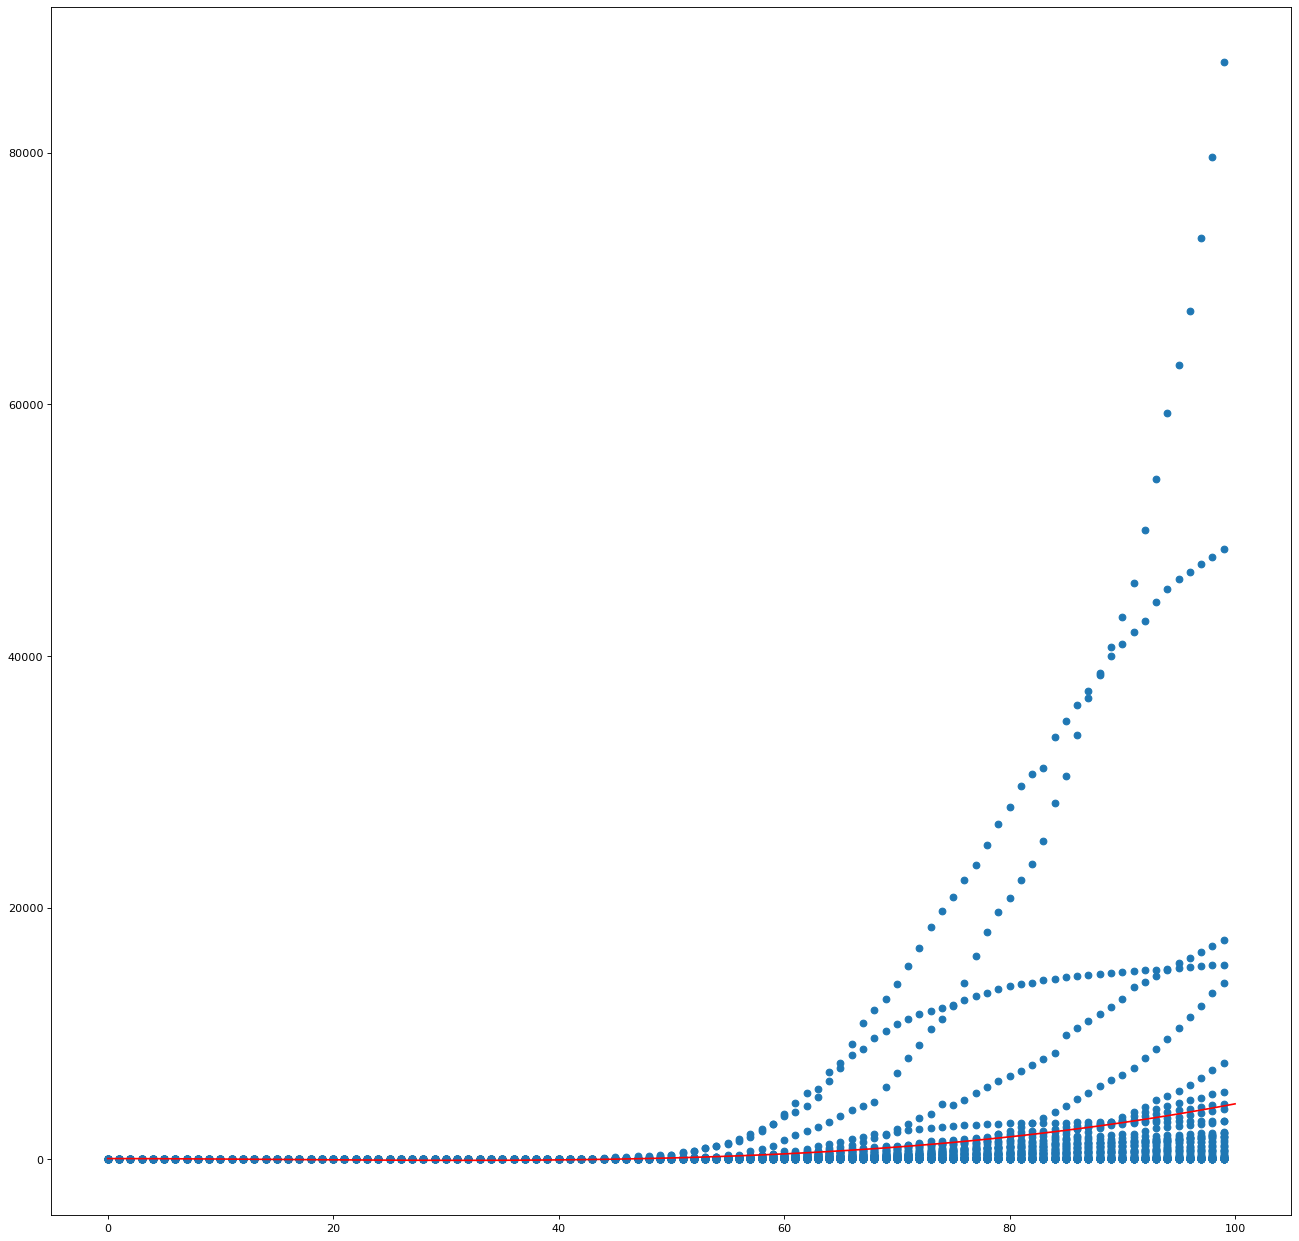

In [19]:
# 1D polynomial regression
model = np.poly1d(np.polyfit(np.transpose(X_train_1[:,2]), np.transpose(y_train[:,0]), 3))

model_x = np.linspace(0, 100, 100)
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.plot(model_x, model(model_x),'r')
plt.show()

In [20]:
#Assignment: Report the mean squared error for prediction using differnt degrers of Polynomial Regression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#1. Report the best model for this data

#2. Repeat for complete data (Change step 3) and report the best model

